In [2]:
import sys
sys.path.append('/data/vision/billf/jwu-phys/texture/ztzhang/code/vtn/')
import vtn
from vtn.functions.grid_sample3d import grid_sample3d
from torch import nn,FloatTensor,DoubleTensor
import torch
import numpy as np
from torch.autograd import Function,Variable,gradcheck
from torch.autograd.function import once_differentiable
import matplotlib
import matplotlib.pyplot as plot
from scipy.io import loadmat
from numba import jit



#numtype = np.float32
#m = loadmat('/data/vision/billf/jwu-phys/shape_oneshot/ztzhang/test/test_orig.mat')


class GridGen3D(Function):
    @staticmethod
    def forward(ctx,voxel_shape,nsamples_factor=1.0, res=128,numtype=np.float64, dist=2.0, fl=0.012, w=0.032):
        n,c,sx,sy,sz = voxel_shape
        nsamples = int(sz*nsamples_factor)
        grid = np.zeros([n,nsamples,res,res,3],dtype=numtype)
        h_linspace = np.linspace(w/2, -w/2, res)
        w_linspace = np.linspace(w/2, -w/2, res)
        H,W = np.meshgrid(h_linspace, w_linspace)
        cam = np.array([[[-dist,0,0]]])
        grid_vec = np.zeros([res,res,3],dtype=numtype)
        grid_vec[:,:,1] = W
        grid_vec[:,:,2] = H
        grid_vec[:,:,0] = -(dist-fl)
        grid_vec = grid_vec-cam
        grid_vec_a = grid_vec * (1/fl)
        grid_vec_b = grid_vec * (3/fl)
        for idn in range(n):
            for ids in range(nsamples):
                grid[idn,ids,:,:,:] = grid_vec_b - (1-ids/nsamples)*(grid_vec_b-grid_vec_a)
        grid = grid + cam
        return torch.from_numpy(grid.astype(numtype))
    def backward(ctx,gradin):
        raise NotImplemented



class calc_stop_prob(Function):
    @staticmethod
    def forward(ctx, aligned_voxel,fake=1):
        #print(aligned_voxel.shape)
        n,c,sx,sy,sz = aligned_voxel.shape
        #print(type(aligned_voxel))
       
        stop_prob = aligned_voxel.new(aligned_voxel.shape)
        stop_prob.zero_()
        #print(stop_prob.shape)
        for idz in range(sz):
            if idz==0:
                stop_prob[:,:,:,:,idz]=aligned_voxel[:,:,:,:,idz]
            else:
                stop_prob[:,:,:,:,idz] = stop_prob[:,:,:,:,idz-1]*((1/aligned_voxel[:,:,:,:,idz-1])-1)*aligned_voxel[:,:,:,:,idz]
        ctx.save_for_backward(stop_prob,aligned_voxel)
        return stop_prob
    @once_differentiable
    def backward(ctx,grad_in):
        stop_prob, aligned_voxel = ctx.saved_tensors
        n,c,sx,sy,sz = stop_prob.shape
        head = stop_prob.new(torch.zeros([n,c,sx,sy]).shape)
        head.zero_()
        delay_sum = stop_prob.new(torch.zeros([n,c,sx,sy]).shape)
        delay_sum.zero_()
        grad_out = stop_prob.new(stop_prob.shape)
        grad_out.zero_()
        stop_prob_weighted = stop_prob*grad_in
        #print(stop_prob_weighted)
        for idz in reversed(range(sz)):
            if idz==sz-1:
                grad_out[:,:,:,:,idz] = stop_prob_weighted[:,:,:,:,idz]/aligned_voxel[:,:,:,:,idz]
                head = stop_prob_weighted[:,:,:,:,idz]/aligned_voxel[:,:,:,:,idz]
            else:
                cur_layer_prob = aligned_voxel[:,:,:,:,idz]
                prev_layer_prob = aligned_voxel[:,:,:,:,idz+1]
                cur_layer_accum_prob = stop_prob_weighted[:,:,:,:,idz]
                v1 = cur_layer_accum_prob/cur_layer_prob
                v2 = head * prev_layer_prob / (1-cur_layer_prob)
                v3 = delay_sum * (1-prev_layer_prob)/(1-cur_layer_prob)
                delay_sum = v2+v3
                head = v1
                grad_out[:,:,:,:,idz] = v1-v2-v3
        return grad_out,None
            
        
        
        
                
            
    

In [3]:
Ggen = GridGen3D()
n = 1
c = 1
sx,sy,sz= [5,5,5]
test_vox = torch.rand([n,c,sx,sy,sz]).double()
grid = Ggen.apply(test_vox.shape, 2.0, 10,np.float64)
out = grid_sample3d(test_vox,grid)
c = calc_stop_prob()
out = torch.clamp(out,0.1, 0.9)
out = out.permute(0,1,3,4,2)
print(out.shape)
out = Variable(out.data,requires_grad=True)
gradcheck(calc_stop_prob().apply, (out,1), eps=1e-6, atol=1e-4)

#vout = c.apply(out)
#vout.backward(Variable(torch.FloatTensor([[[[[1,0,0]]]]])))
#print(out.grad)
#plot.imshow(np.sum(vout.data.numpy()[0,0,:,:,:],axis=2))
#plot.colorbar()
#loss = torch.sum(vout)
#grad_in = torch.ones([n,1,sz,sz,sz])
#out.data.shape
#print(vout.data)

torch.Size([1, 1, 10, 10, 10])


True

In [20]:
# forward_consistency_check
n = 1
c = 1
sx,sy,sz= [5,5,5]
test_vox = torch.rand([n,c,sx,sy,sz])
grid = Ggen.apply(test_vox.shape, 2.0, 10,np.float32)
out = grid_sample3d(test_vox,grid)
c = calc_stop_prob()
out = torch.clamp(out,0.1, 0.9)
out = out.permute(0,1,3,4,2)
out_cpu = Variable(out.data,requires_grad=True)
cpu_calc = calc_stop_prob()
cpu_out = cpu_calc.apply(out_cpu)
grad_in = torch.rand(cpu_out.shape)
grad_in_cpu = Variable(grad_in)
cpu_grad = cpu_out.backward(grad_in_cpu)

In [21]:
from calc_prob.functions.calc_prob import CalcStopProb
out_gpu = Variable(out.data.cuda(),requires_grad=True)
grad_in_gpu = Variable(grad_in.cuda())
with torch.autograd.profiler.profile() as prof:
    gpu_out = CalcStopProb.apply(out_gpu)
    gpu_grad = gpu_out.backward(grad_in_gpu)
print(prof)

-------------------------------------  ---------------  ---------------  ---------------  ---------------  ---------------
Name                                          CPU time        CUDA time            Calls        CPU total       CUDA total
-------------------------------------  ---------------  ---------------  ---------------  ---------------  ---------------
CalcStopProb                                 248.555us          0.000us                1        248.555us          0.000us
N5torch8autograd9GraphRootE                   14.524us          0.000us                1         14.524us          0.000us
CalcStopProbBackward                         604.310us          0.000us                1        604.310us          0.000us
N5torch8autograd12DelayedErrorE                8.405us          0.000us                1          8.405us          0.000us
N5torch8autograd14AccumulateGradE             65.242us          0.000us                1         65.242us          0.000us
N5torch8autograd

In [269]:
grid.data.shape

torch.Size([2, 256, 128, 128, 3])

In [12]:
out = grid_sample3d(test_vox,grid)
s = out.data.numpy()

In [13]:
s.shape

(2, 1, 384, 128, 128)

In [14]:
v = np.transpose(s,(0,1,3,4,2))
aligned_voxels = v+1e-6
n,c,sx,sy,sz = aligned_voxels.shape
sil = np.zeros([n,c,sx,sy])
temp_prob = np.zeros([n,c,sx,sy,sz])
for idz in range(sz):
    if idz==0:
        temp_prob[:,:,:,:,idz]=aligned_voxels[:,:,:,:,idz]
    else:
        temp_prob[:,:,:,:,idz] = temp_prob[:,:,:,:,idz-1]*((1/aligned_voxels[:,:,:,:,idz-1])-1)*aligned_voxels[:,:,:,:,idz]
exp_sil = np.sum(temp_prob, axis=4)
depth = np.linspace(10,20,sz)
d = np.dot(temp_prob,depth)

In [ ]:
temp_prob.shape
depth.shape

In [20]:
t1 = torch.from_numpy(temp_prob.astype(np.float32))
depth = np.linspace(10,20,sz)
t2 = torch.from_numpy(depth.astype(np.float32))
out = torch.matmul(t1,t2)
np.max(out.numpy()-d)

8.83728862532962e-07

In [312]:
from time import time
t = time()
test(s)
print(time()-t)

2.57454252243042


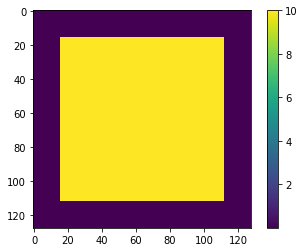

In [298]:
plot.imshow(d[0,0,:,:])
plot.colorbar()

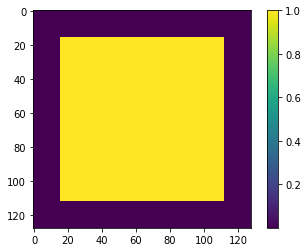

In [301]:
plot.imshow(exp_sil[0,0,:,:])
plot.colorbar()

In [119]:
a,b,c,d,e = out.data.shape